In [1]:
pip install opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [29]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [2]:
# Ensure memory growth is enabled for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
data_dir = "E:/Mangrove project/MobilenetV2/Data"
class_names = os.listdir(data_dir)
class_names.sort()
print(f'Class names: {class_names}')

Class names: ['Acrostichum aureum', 'Avicennia rumphiana', 'Lumnitzera racemosa', 'Nypa fruticans', 'Rhizophora mucronata']


In [16]:
image_exts = ['jpeg', 'png', 'jpg', 'bmp']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)


In [17]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(224, 224), batch_size=32, label_mode='categorical')
data = data.map(lambda x, y: (x / 255, y))

Found 4991 files belonging to 5 classes.


In [18]:
# Split the dataset
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1) + 1

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [30]:
# Build the model using Functional API
input_shape = (224, 224, 3)
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [31]:
logdir = "E:/Mangrove project/MobilenetV2/logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 68s 591ms/step - accuracy: 0.8214 - loss: 0.4701 - val_accuracy: 0.9869 - val_loss: 0.0431
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 67s 608ms/step - accuracy: 0.9750 - loss: 0.0800 - val_accuracy: 0.9899 - val_loss: 0.0402
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 67s 609ms/step - accuracy: 0.9830 - loss: 0.0551 - val_accuracy: 0.9950 - val_loss: 0.0162
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 67s 610ms/step - accuracy: 0.9888 - loss: 0.0391 - val_accuracy: 0.9929 - val_loss: 0.0227
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 67s 612ms/step - accuracy: 0.9911 - loss: 0.0269 - val_accuracy: 0.9909 - val_loss: 0.0242
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 63s 570ms/step - accuracy: 0.9944 - loss: 0.0219 - val_accuracy: 0.9960 - val_loss: 0.0160
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 61s 556ms/step - accuracy: 0.9891 - loss: 0.0281 - val_accuracy: 0.9929 - val_loss: 0.0186
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 61s 555ms/step - accuracy: 0.9936 - loss: 0

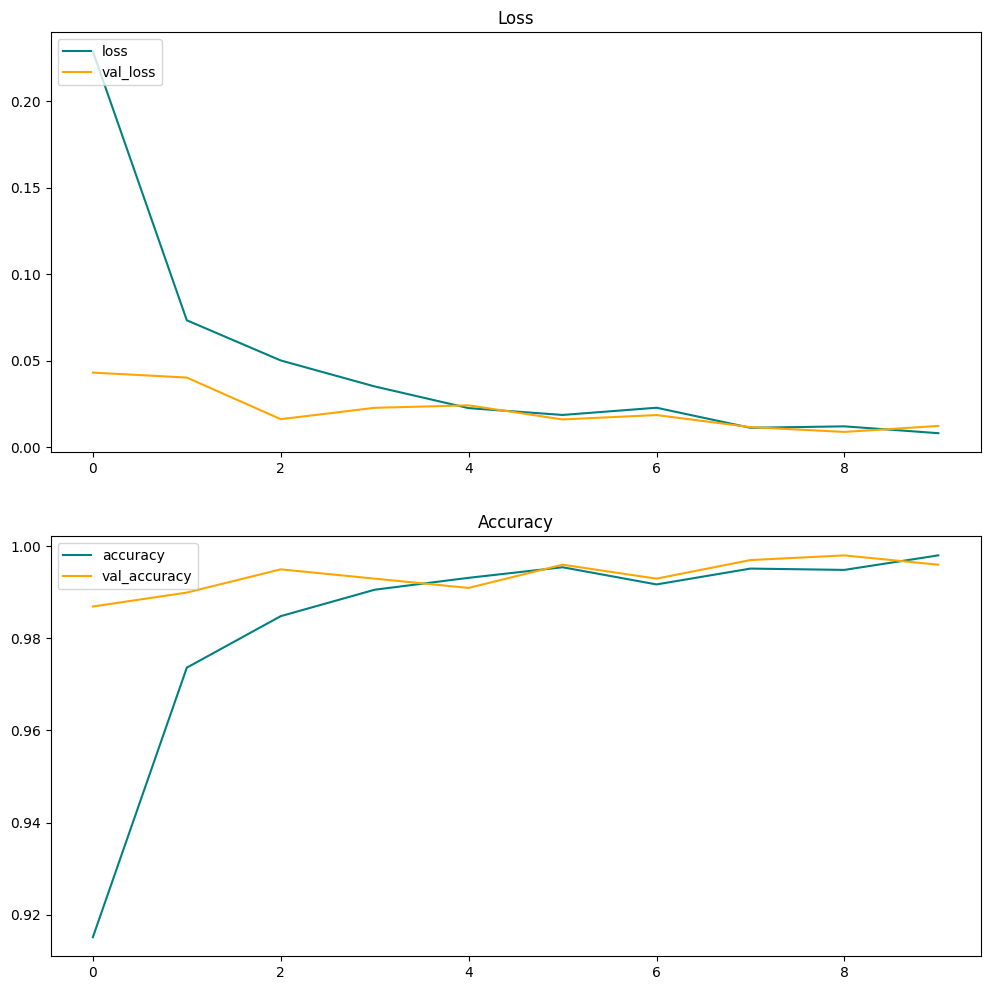

In [33]:
# Plot the training history
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
ax[0].set_title('Loss')
ax[0].legend(loc="upper left")

ax[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend(loc="upper left")

plt.show()

In [34]:
# Evaluate the model
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
Precision: 0.9980430603027344, Recall: 0.9980430603027344, Accuracy: 0.9980430603027344


In [35]:
# Save the model
model_path = r"E:\Mangrove project\models\mobilenetv2_imageclassifier.keras"
model.save(model_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step


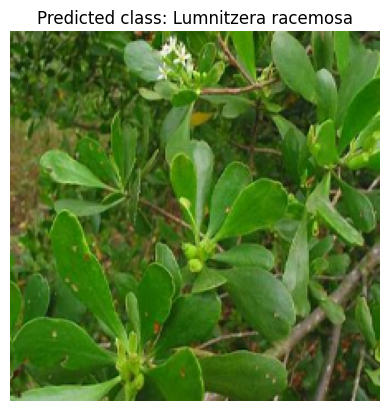

Predicted class probabilities: [[1.4543310e-06 7.7907671e-06 9.9998486e-01 8.8526755e-11 5.9891722e-06]]
Predicted class: Lumnitzera racemosa


In [42]:
# Load and test the model with a new image
model = tf.keras.models.load_model(model_path)

img_path = r"E:\Mangrove project\MobilenetV2\lrTest.jpg"
img = cv2.imread(img_path)

# Check if the image was loaded successfully
if img is None:
    print(f"Error: Failed to load image at {img_path}")
else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    resize = tf.image.resize(img, (224, 224))
    input_image = np.expand_dims(resize, 0) / 255.0  # Normalize and add batch dimension

    # Predict
    yhat = model.predict(input_image)
    predicted_class_idx = np.argmax(yhat, axis=1)[0]
    predicted_class_name = class_names[predicted_class_idx]

    # Display results
    plt.imshow(resize.numpy().astype(np.uint8))
    plt.title(f'Predicted class: {predicted_class_name}')
    plt.axis('off')
    plt.show()

    print(f'Predicted class probabilities: {yhat}')
    print(f'Predicted class: {predicted_class_name}')